### Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/AN2DL/Homework 2 copia

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/AN2DL/Homework 2 copia


### Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [ ]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler

### Load and process data

In [ ]:
# Load the dataset without padding
dataset = np.load('datasets/training_no_padding.npy', allow_pickle=True)

In [ ]:
# Shuffle the dataset
np.random.shuffle(dataset)

In [ ]:
# Convert each time series type from float64 to float32
for i in range(len(dataset)):
  dataset[i]=dataset[i].astype('float32')

### Direct Forecasting

In [ ]:
# Select 3800 time series as test set and the remaining as training set
test_size = 3800
X_train_raw = dataset[:-test_size]
X_test_raw = dataset[-test_size:]

In [ ]:
# Print shapes
print("Train shape: " + str(X_train_raw.shape))
print("Test shape: "+  str(X_test_raw.shape))

In [ ]:
# Define window and size
window = 200
stride = 5

In [ ]:
def build_sequences(df, window, stride, telescope):

    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df
    temp_label = df
    padding_check = len(df)%window

    if(padding_check != 0):

        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float32')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float32')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for series in temp_df:
      for idx in np.arange(0,len(series)-window-telescope,stride):
          dataset.append(series[idx:idx+window])
          labels.append(series[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [ ]:
# Define telescope parameter
telescope = 18

In [ ]:
# Assign variables
direct_telescope = telescope

In [ ]:
# Build sequences to better fit the input form for the model, both for training and testing
X_train, y_train = build_sequences(X_train_raw, window, stride, direct_telescope)
X_test, y_test = build_sequences(X_test_raw, window, stride, direct_telescope)

In [ ]:
# Expand training dimension to fit the input shape
X_train=np.expand_dims(X_train,axis=-1)

In [ ]:
# Print the sequences' shape
print("X Train sequence shape: " + str(X_train.shape))
print("y Train sequence shape: " +  str(y_train.shape))
print("X Test sequence shape: " + str(X_test.shape))
print("y Test sequence shape: " +  str(y_test.shape))

In [ ]:
# Define training parameters
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 512
epochs = 100

In [ ]:
# Print shapes to check they fit the model
print("Input shape: " + str(input_shape))
print("Output shape: " + str(output_shape))

In [ ]:
def build_CONV_LSTM_with_attention_and_fc(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise, we want input time steps to be >= output time steps"

    # Define the input layer with the specified shape
    input_layer = tf.keras.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    # Add a 1D Convolution layer with 64 filters and a kernel size of 3
    x = tfkl.Conv1D(64, 3, padding='same', activation='relu', name='conv1')(x)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 5
    x = tfkl.Conv1D(128, 5, padding='same', activation='relu', name='conv2')(x)

    # Add an Attention layer
    x = tfkl.Attention()([x, x])

    # Calculate the size to crop from the output to match the output shape
    crop_size = 200-18

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(1, 3, padding='same', name='output_layer')(x)

    # Crop the output to the desired length
    pre_output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    output_layer=tfkl.Flatten()(pre_output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_FC_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

Model: "CONV_LSTM_FC_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 200, 1)]             0         []                            
                                                                                                  
 bidirectional_lstm (Bidire  (None, 200, 128)             33792     ['input_layer[0][0]']         
 ctional)                                                                                         
                                                                                                  
 conv1 (Conv1D)              (None, 200, 64)              24640     ['bidirectional_lstm[0][0]']  
                                                                                                  
 conv2 (Conv1D)              (None, 200, 128)             41088     ['conv1[0][0]

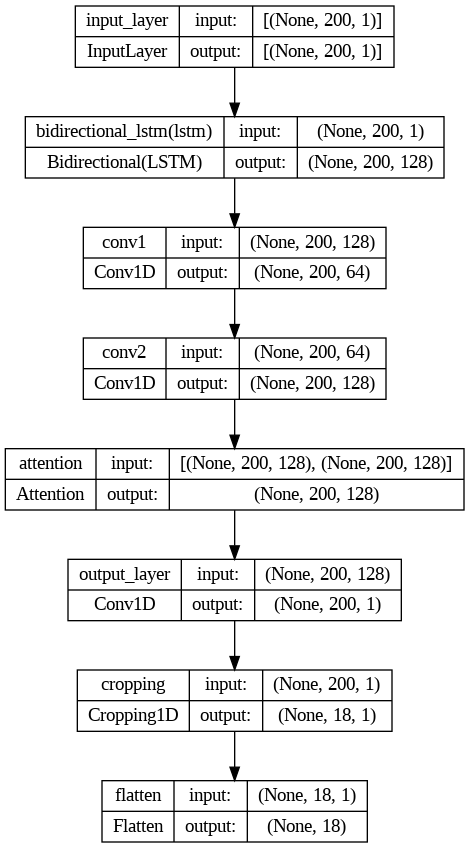

In [ ]:
# Build the model and print a summary
model = build_CONV_LSTM_with_attention_and_fc(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=8, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/100
701/701 [==============================] - 66s 73ms/step - loss: 0.0321 - val_loss: 0.0142 - lr: 0.0010
Epoch 2/100
701/701 [==============================] - 48s 68ms/step - loss: 0.0126 - val_loss: 0.0126 - lr: 0.0010
Epoch 3/100
701/701 [==============================] - 48s 68ms/step - loss: 0.0121 - val_loss: 0.0133 - lr: 0.0010
Epoch 4/100
701/701 [==============================] - 48s 68ms/step - loss: 0.0115 - val_loss: 0.0113 - lr: 0.0010
Epoch 5/100
701/701 [==============================] - 48s 68ms/step - loss: 0.0109 - val_loss: 0.0112 - lr: 0.0010
Epoch 6/100
701/701 [==============================] - 48s 68ms/step - loss: 0.0105 - val_loss: 0.0114 - lr: 0.0010
Epoch 7/100
701/701 [==============================] - 48s 68ms/step - loss: 0.0103 - val_loss: 0.0100 - lr: 0.0010
Epoch 8/100
701/701 [==============================] - 48s 68ms/step - loss: 0.0101 - val_loss: 0.0108 - lr: 0.0010
Epoch 9/100
701/701 [==============================] - 48s 68ms/step - l

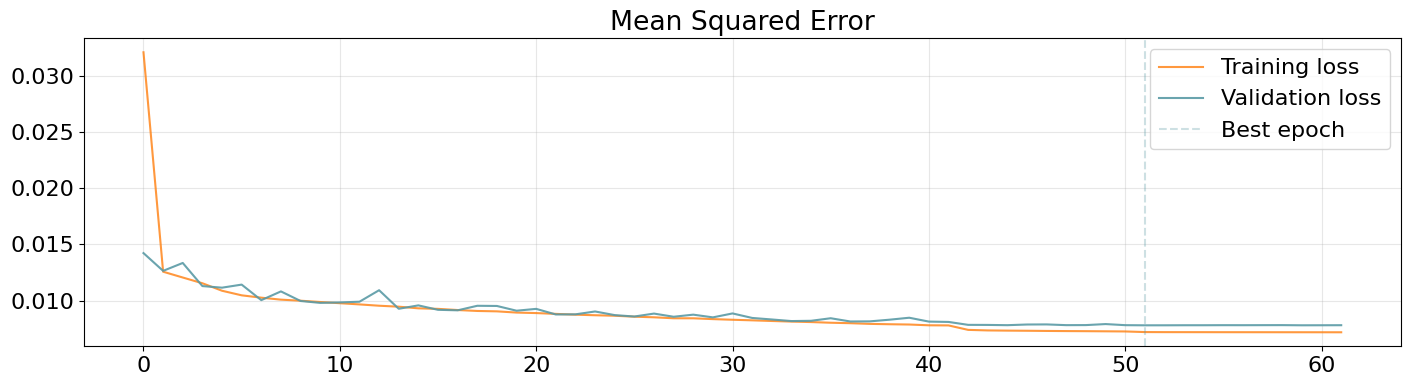

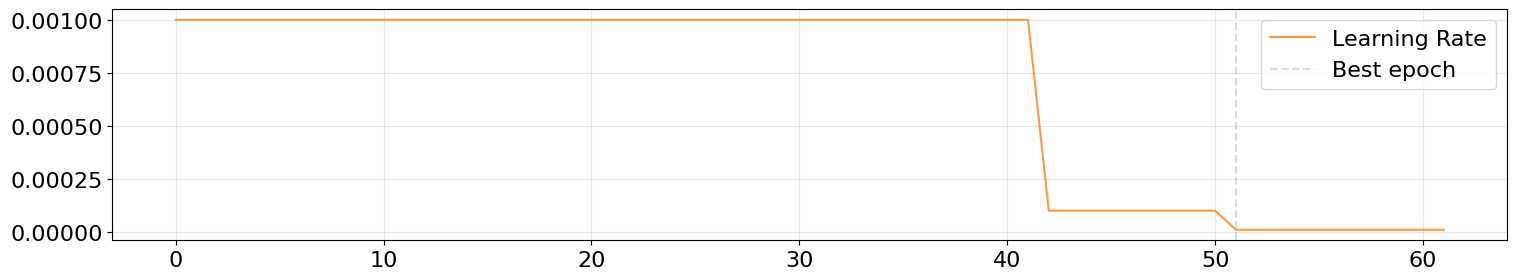

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# Save and reload
model.save('Attention')
model = tfk.models.load_model('Attention')

Test evaluation

In [ ]:
# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (34551, 18)
Mean Squared Error: 0.007904945872724056
Mean Absolute Error: 0.057907585054636
